In [1]:

def group_amplicons(amplicon_data, length_threshold, melting_temp_threshold):
    amplicons = amplicon_data['amplicons']
    melting_temps = amplicon_data['melting_temperatures']
    grouped = []
    used_indices = set()

    for i, amplicon in enumerate(amplicons):
        if i in used_indices:
            continue

        current_group = [amplicon]
        used_indices.add(i)

        for j in range(i + 1, len(amplicons)):
            if j not in used_indices:
                length_diff = abs(len(amplicon) - len(amplicons[j]))
                melting_temp_diff = abs(melting_temps[i] - melting_temps[j])

                if length_diff <= length_threshold and melting_temp_diff <= melting_temp_threshold:
                    current_group.append(amplicons[j])
                    used_indices.add(j)

        grouped.append(current_group)

    return grouped


def create_combined_dataframe(grouped_amplicons, amplicon_dict):
    data = {'Group': [], 'Name': [], 'Length': [], 'Melting Temperature 1': [], 'Melting Temperature 2': [], 'Melting Temperature 3': []}

    for group_number, group in enumerate(grouped_amplicons):
        for amplicon in group:
            index = amplicon_dict['amplicons'].index(amplicon)
            melting_temp1 = amplicon_dict['melting_temperatures'][index]
            melting_temp2 = melting_temp1 - 2
            melting_temp3 = melting_temp1 - 6

            data['Group'].append(group_number)
            data['Name'].append(amplicon.name)
            data['Length'].append(len(amplicon))
            data['Melting Temperature 1'].append(melting_temp1)
            data['Melting Temperature 2'].append(melting_temp2)
            data['Melting Temperature 3'].append(melting_temp3)

    combined_df = pd.DataFrame(data)
    return combined_df

# 02_Integration_of_GOE_regulators_into_pRM4e_PkasO

In order to clone all the regulators into an integrative vector using a standardized cloning framework, the existing pRM4e plasmid needs to be adjusted. This will result in  , a plasmid with pKaso* + RBS flanked by a StuI restriction site for easy linearization for Gibson Assemblies. 

In [2]:
from teemi.design.fetch_sequences import read_genbank_files
goe_regulators = read_genbank_files('../wet_lab_notebooks/data_for_wetlab/GOE_regulators.gb')
goe_regulators

[SeqRecord(seq=Seq('GTGACCCAGCCCGCCGCCGACCGCCACATCCCCCAGGCCCCGAACCGGATGCCG...TGA'), id='LLPMBPKK_00292', name='LLPMBPKK_00292', description='regulatory (smcogs) SMCOG1016:LuxR family DNA-binding response regulator (Score: 187.1; E-value: 4.1e-57)', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGATGAAGGGGATGCCGCCGGTGGCCCCGCCTGCTGGTTCCGGTTCGTACGGA...TGA'), id='LLPMBPKK_00328', name='LLPMBPKK_00328', description='regulatory (smcogs) SMCOG1149:LuxR family transcriptional regulator (Score: 972.3; E-value: 4.8e-294)', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGACCGACACCCCCATCCGTCTCCTCCTGGCCGACGACCACCCCGTGGTCCGC...TGA'), id='LLPMBPKK_00586', name='LLPMBPKK_00586', description='regulatory (smcogs) SMCOG1016:LuxR family DNA-binding response regulator (Score: 166.8; E-value: 6.4e-51)', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGGCCGTGTGAGCGGGGACACATACGGCGGGGAACGGATCGACTTCCGCAAC...TGA'), id='LLPMBPKK_01488', name='LLPMBPKK_01488', description='regulatory (smcogs) SMCOG1041:transcriptional regulator, SARP family (Score: 

In [3]:
import pandas as pd

In [4]:
primers_df = pd.read_excel('../wet_lab_notebooks/data_for_wetlab/primers_melting_temperatures.xlsx')
primers_df.head()


,Unnamed: 0,template,f_primer_anneal(5-3),r_primer_anneal(5-3),f_tm_q5,r_tm_q5,ta_q5,f_tm_taq,r_tm_taq,ta_taq,f_primer_sequences(5-3),r_primer_sequences(5-3)
0,0,LLPMBPKK_00292,GTGACCCAGCCCGCC,TCATTCGGCGGCGGAGC,70,72,71,67,68,62,GGCGAGCAACGGAGGTACGGACAGGGTGACCCAGCCCGCC,CGCAAGCCGCCACTCGAACGGAAGGTCATTCGGCGGCGGAGC
1,1,LLPMBPKK_00328,ATGATGAAGGGGATGCCGC,TCAGCCGGAGTCGGTG,68,67,68,64,63,59,GGCGAGCAACGGAGGTACGGACAGGATGATGAAGGGGATGCCGC,CGCAAGCCGCCACTCGAACGGAAGGTCAGCCGGAGTCGGTG
2,2,LLPMBPKK_00586,GTGACCGACACCCCC,TCAGCGGCGGATGAGG,65,68,66,62,64,57,GGCGAGCAACGGAGGTACGGACAGGGTGACCGACACCCCC,CGCAAGCCGCCACTCGAACGGAAGGTCAGCGGCGGATGAGG
3,3,LLPMBPKK_01488,ATGGGCCGTGTGAGCG,TCATCGGTTCCCCTCTTCTGC,69,69,70,65,65,60,GGCGAGCAACGGAGGTACGGACAGGATGGGCCGTGTGAGCG,CGCAAGCCGCCACTCGAACGGAAGGTCATCGGTTCCCCTCTTCTGC
4,4,LLPMBPKK_02197,GTGGCTCTGTTCCACATGCT,TCATGCAAGGGTCGGGAA,68,66,67,63,62,57,GGCGAGCAACGGAGGTACGGACAGGGTGGCTCTGTTCCACATGCT,CGCAAGCCGCCACTCGAACGGAAGGTCATGCAAGGGTCGGGAA


In [5]:
from pydna.primer import Primer
from pydna.dseqrecord import Dseqrecord

In [6]:
f_primers_list = [Primer(seq,id= template) for seq, template in zip(primers_df['f_primer_sequences(5-3)'], primers_df['template'])]
r_primers_list = [Primer(seq,id= template) for seq, template in zip(primers_df['r_primer_sequences(5-3)'], primers_df['template'])]
clean_seq = [Dseqrecord(seq, id= seq.id) for seq in goe_regulators]

Lets make amplicons

In [7]:
from pydna.amplify import pcr
x = 0
list_of_amplicons = []
for i in range(len(clean_seq)):
    try:
        amplicon = pcr(f_primers_list[i], r_primers_list[i], clean_seq[i])
        amplicon.name = clean_seq[i].id + "_amplicon"
        list_of_amplicons.append(amplicon)
    except ValueError:
        x +=1 



### 01/12/2023 - PCR #1
Meanwhile i tried to amplify two fragmetns from the gDNA with 3ng/µl.

- LLPMBPKK_02635
Annealing: 66-64-60
659 bp - did for 40 seconds

- LLPMBPKK_07531
Anealing: 66-64-60
2471 bp - did 100 seconds 

LLPMBPKK_02635_amplicon
LLPMBPKK_07531_amplicon


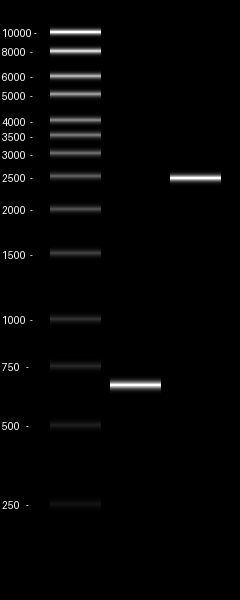

In [8]:
list_of_sub_amplicons = ['LLPMBPKK_02635_amplicon', 'LLPMBPKK_07531_amplicon']
gel_amplicons = [amplicon for amplicon in list_of_amplicons if str(amplicon.name) in list_of_sub_amplicons]

import pydna.gel
bands = gel_amplicons
for band in bands:
    print(band.name)
pydna.gel.gel([pydna.ladders.GeneRuler_1kb,*[[band] for band in bands]])

The actual gel

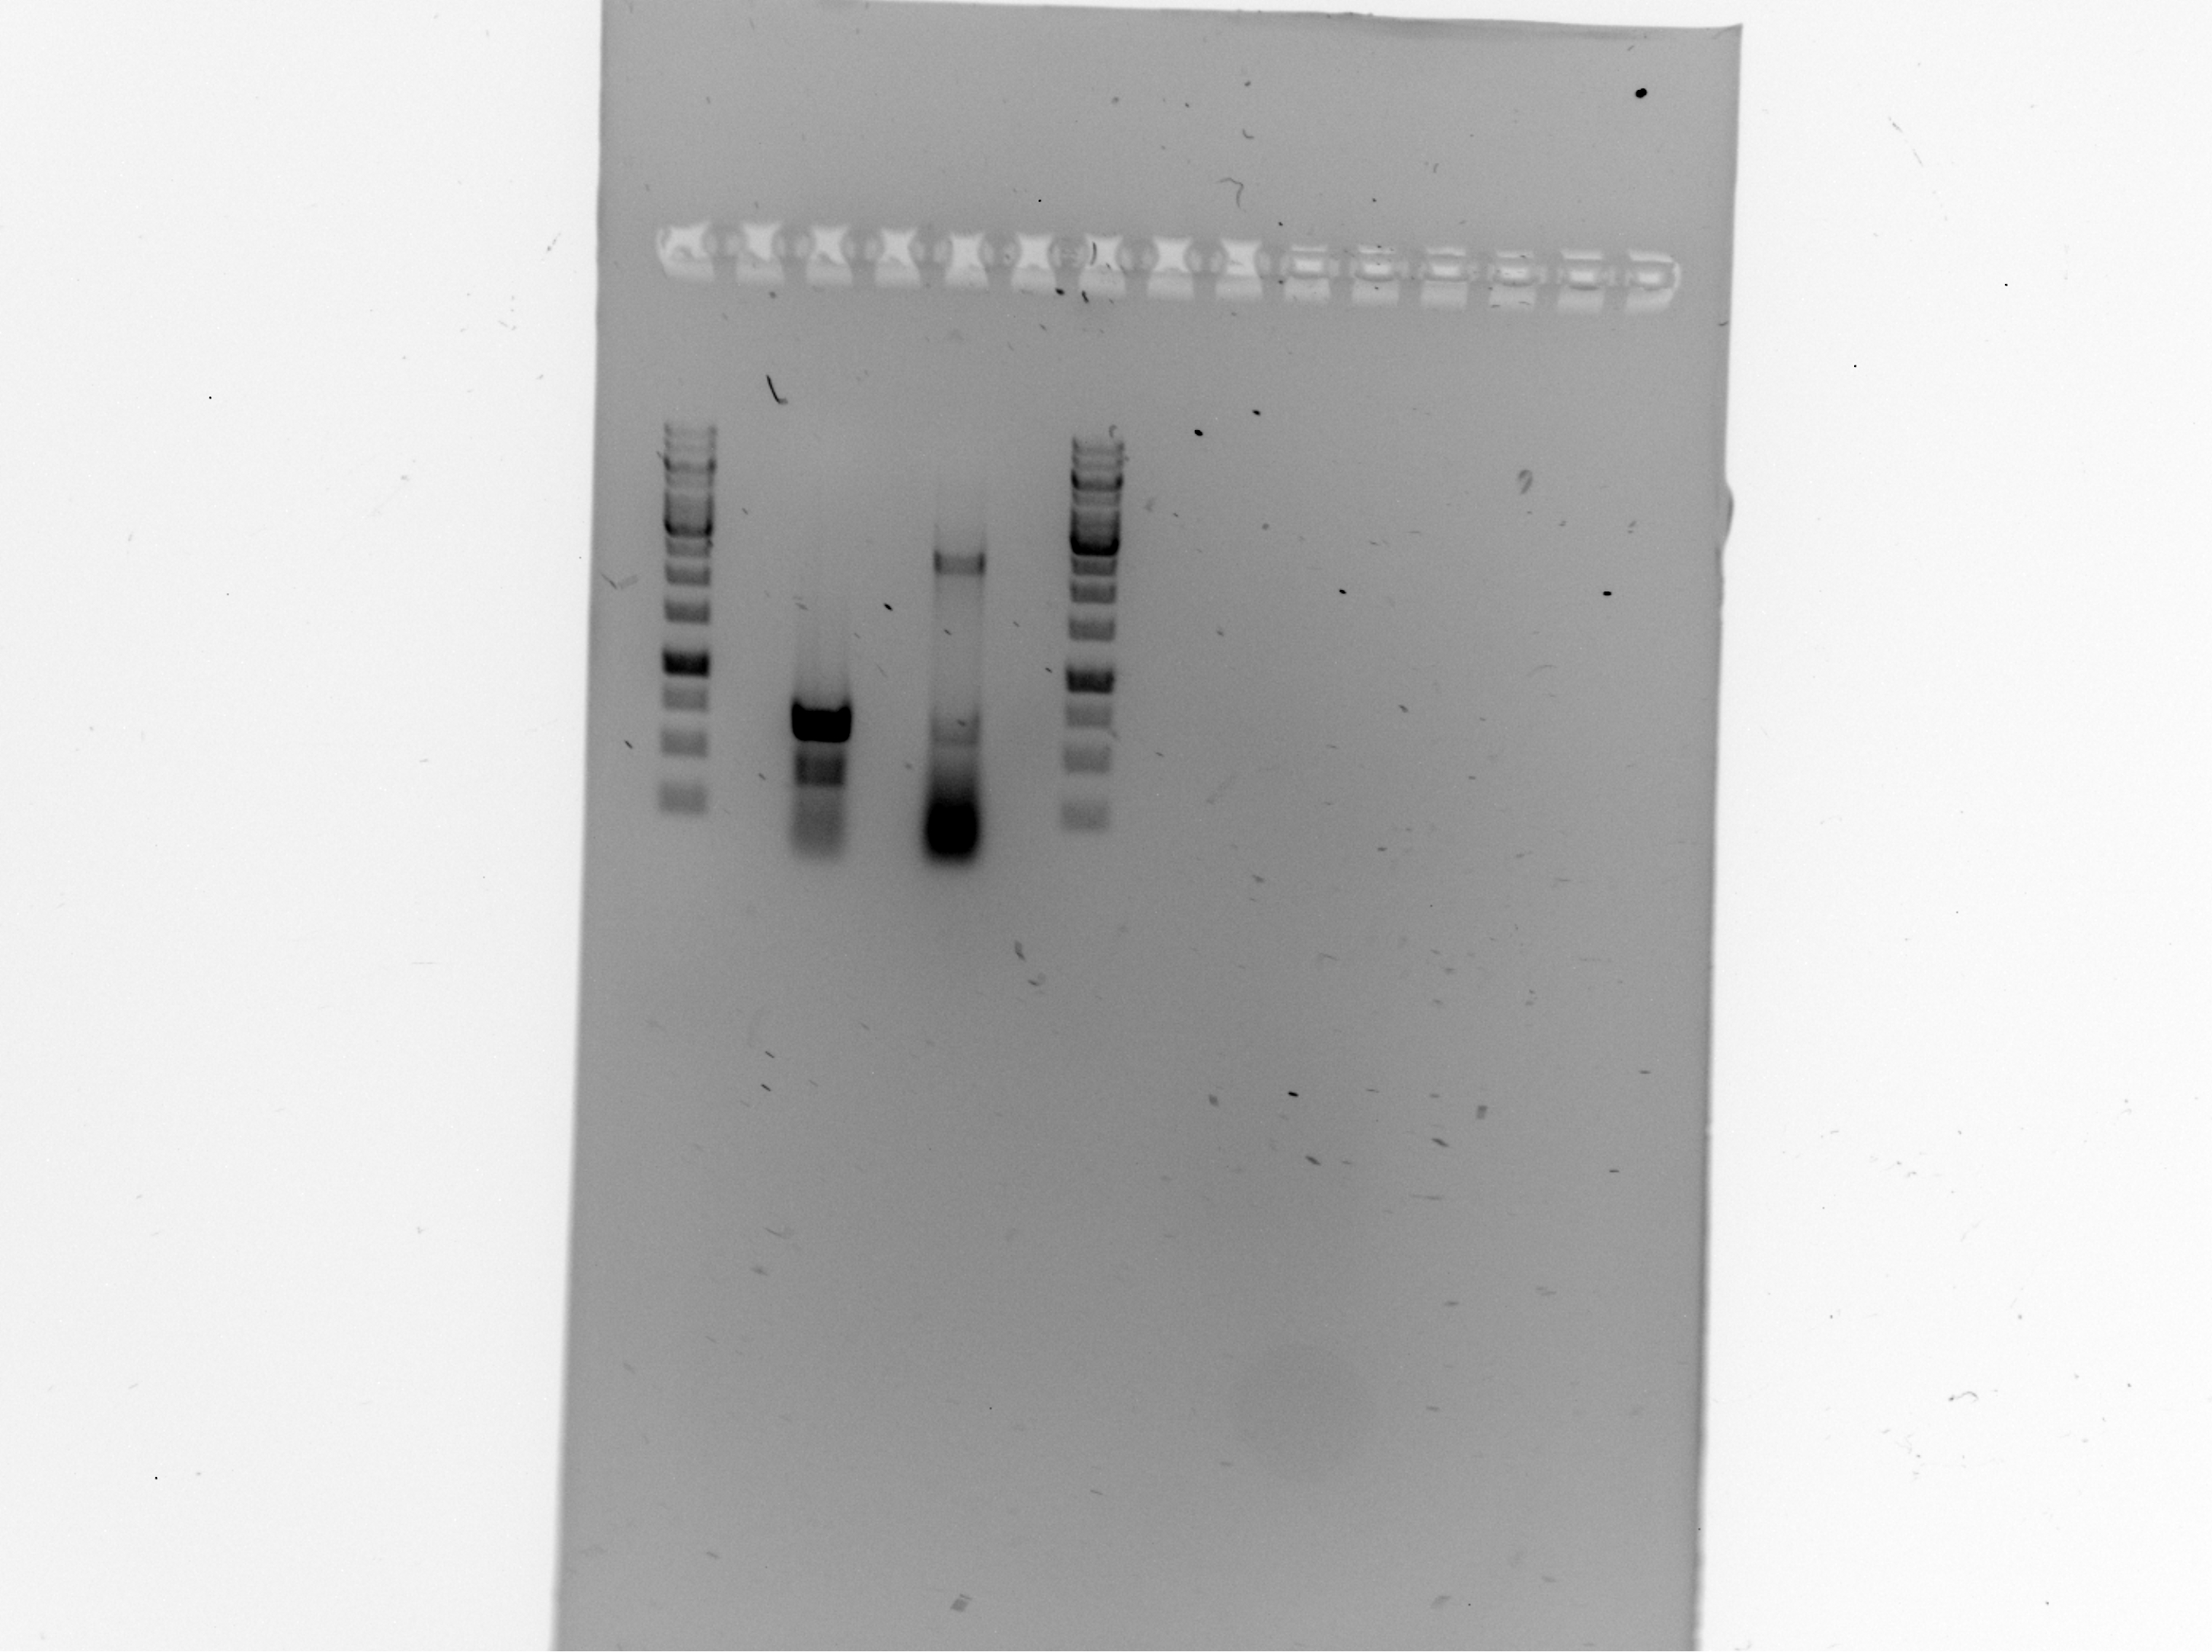

In [9]:
path_to_gel = '../wet_lab_notebooks/data_for_wetlab/bioimager/2023-12-01_15h06m45s_gDNA_amplification_test.jpg'
from IPython.display import Image
Image(filename=path_to_gel) 


Succesfull PCR. 

## 07/12/2023 - Second round of amplification

Let's simulate all pcrs now

In [10]:
from pydna.primer import Primer
from pydna.amplify import pcr

In [11]:
from pydna.primer import Primer
f_primers_list = [Primer(seq,id= template) for seq, template in zip(primers_df['f_primer_sequences(5-3)'], primers_df['template'])]
r_primers_list = [Primer(seq,id= template) for seq, template in zip(primers_df['r_primer_sequences(5-3)'], primers_df['template'])]
r_primers_list
from pydna.amplify import pcr
## analyze primer binding and homo-and hetero dimers 
x = 0
list_of_amplicons = []
for i in range(len(clean_seq)):
    try:
        amplicon = pcr(f_primers_list[i], r_primers_list[i], clean_seq[i])
        amplicon.name = clean_seq[i].id + "_amplicon"
        print(amplicon.name , len(amplicon))
        print(amplicon.figure()+ '\n')
        list_of_amplicons.append(amplicon)
    except ValueError:
        x +=1 
        print('\n######## No PCR product!#######', x)
        print(clean_seq[i] )
        print('###############################' )


LLPMBPKK_00292_amplicon 863
                         5GTGACCCAGCCCGCC...GCTCCGCCGCCGAATGA3
                                            |||||||||||||||||
                                           3CGAGGCGGCGGCTTACTGGAAGGCAAGCTCACCGCCGAACGC5
5GGCGAGCAACGGAGGTACGGACAGGGTGACCCAGCCCGCC3
                          |||||||||||||||
                         3CACTGGGTCGGGCGG...CGAGGCGGCGGCTTACT5

LLPMBPKK_00328_amplicon 2909
                         5ATGATGAAGGGGATGCCGC...CACCGACTCCGGCTGA3
                                                ||||||||||||||||
                                               3GTGGCTGAGGCCGACTGGAAGGCAAGCTCACCGCCGAACGC5
5GGCGAGCAACGGAGGTACGGACAGGATGATGAAGGGGATGCCGC3
                          |||||||||||||||||||
                         3TACTACTTCCCCTACGGCG...GTGGCTGAGGCCGACT5

LLPMBPKK_00586_amplicon 686
                         5GTGACCGACACCCCC...CCTCATCCGCCGCTGA3
                                            ||||||||||||||||
                                           3GGAG

In [12]:
q5_melting_list = list(primers_df['ta_q5'])

In [13]:
amplicon_dict = {'amplicons': list_of_amplicons, 'melting_temperatures':q5_melting_list}
amplicon_dict

{'amplicons': [Amplicon(863),
  Amplicon(2909),
  Amplicon(686),
  Amplicon(2369),
  Amplicon(872),
  Amplicon(1403),
  Amplicon(704),
  Amplicon(863),
  Amplicon(659),
  Amplicon(698),
  Amplicon(836),
  Amplicon(938),
  Amplicon(3470),
  Amplicon(1880),
  Amplicon(1271),
  Amplicon(2471),
  Amplicon(2966),
  Amplicon(2354)],
 'melting_temperatures': [71,
  68,
  66,
  70,
  67,
  66,
  67,
  67,
  66,
  68,
  67,
  68,
  66,
  69,
  66,
  66,
  67,
  69]}

In [14]:


# Group the amplicons with a threshold (e.g., 100)
grouped_amplicons = group_amplicons(amplicon_dict, 500, 2)

# Print the groups and the calculated value
for i, group in enumerate(grouped_amplicons):
    print(f'Group {i}:')
    
    # Find the longest length in the group
    longest_length = max(len(amplicon) for amplicon in group)

    # Perform the calculation
    calculated_value = (longest_length / 1000) * 40

    for amplicon in group:
        index = amplicon_dict['amplicons'].index(amplicon)
        melting_temp = amplicon_dict['melting_temperatures'][index]
        print(f'  {amplicon.name} (Length: {len(amplicon)}, Melting Temp1: {melting_temp}, Melting Temp2: {melting_temp-2}, Melting Temp3: {melting_temp-6})')

    # Print the calculated value
    print(f'Calculated elongation for Group {i}: {calculated_value:.2f}\n')


Group 0:
  LLPMBPKK_00292_amplicon (Length: 863, Melting Temp1: 71, Melting Temp2: 69, Melting Temp3: 65)
Calculated elongation for Group 0: 34.52

Group 1:
  LLPMBPKK_00328_amplicon (Length: 2909, Melting Temp1: 68, Melting Temp2: 66, Melting Temp3: 62)
  LLPMBPKK_07531_amplicon (Length: 2471, Melting Temp1: 66, Melting Temp2: 64, Melting Temp3: 60)
  LLPMBPKK_07744_amplicon (Length: 2966, Melting Temp1: 67, Melting Temp2: 65, Melting Temp3: 61)
Calculated elongation for Group 1: 118.64

Group 2:
  LLPMBPKK_00586_amplicon (Length: 686, Melting Temp1: 66, Melting Temp2: 64, Melting Temp3: 60)
  LLPMBPKK_02197_amplicon (Length: 872, Melting Temp1: 67, Melting Temp2: 65, Melting Temp3: 61)
  LLPMBPKK_02563_amplicon (Length: 704, Melting Temp1: 67, Melting Temp2: 65, Melting Temp3: 61)
  LLPMBPKK_02633_amplicon (Length: 863, Melting Temp1: 67, Melting Temp2: 65, Melting Temp3: 61)
  LLPMBPKK_02635_amplicon (Length: 659, Melting Temp1: 66, Melting Temp2: 64, Melting Temp3: 60)
  LLPMBPKK_0

In [15]:
import pandas as pd
combined_amplicons_df = create_combined_dataframe(grouped_amplicons, amplicon_dict)
combined_amplicons_df



,Group,Name,Length,Melting Temperature 1,Melting Temperature 2,Melting Temperature 3
0,0,LLPMBPKK_00292_amplicon,863,71,69,65
1,1,LLPMBPKK_00328_amplicon,2909,68,66,62
2,1,LLPMBPKK_07531_amplicon,2471,66,64,60
3,1,LLPMBPKK_07744_amplicon,2966,67,65,61
4,2,LLPMBPKK_00586_amplicon,686,66,64,60
5,2,LLPMBPKK_02197_amplicon,872,67,65,61
6,2,LLPMBPKK_02563_amplicon,704,67,65,61
7,2,LLPMBPKK_02633_amplicon,863,67,65,61
8,2,LLPMBPKK_02635_amplicon,659,66,64,60
9,2,LLPMBPKK_02637_amplicon,698,68,66,62


Let's perform the second PCR's now that they have been grouped and simulated. We have these primers available. 

| template       | ta_q5 | ta_taq | F_PRIMER | R_PRIMER |
| -------------- | ----- | ------ | -------- | -------- |
| LLPMBPKK_00328 | 68    | 59     | CW_961   | CW_979   |
| LLPMBPKK_01488 | 70    | 60     | CW_963   | CW_981   |
| LLPMBPKK_02563 | 67    | 57     | CW_966   | CW_984   |
| LLPMBPKK_02637 | 68    | 58     | CW_969   | CW_987   |
| LLPMBPKK_05992 | 68    | 59     | CW_971   | CW_989   |
| LLPMBPKK_06907 | 66    | 56     | CW_974   | CW_992   |